# Dataset exploration

1. Import dependencies

In [18]:
import pandas as pd
import sys

sys.path.append('..')
from src.definitions import RAW_DATA_FOLDER

## Span detection

In [19]:
span_detection_tbl = pd.read_parquet(RAW_DATA_FOLDER / "span-detection.parquet")

span_detection_tbl.head(5)

,id,content,lang,manipulative,techniques,trigger_words
0,0bb0c7fa-101b-4583-a5f9-9d503339141c,Новий огляд мапи DeepState від російського вій...,uk,True,"[euphoria, loaded_language]","[[27, 63], [65, 88], [90, 183], [186, 308]]"
1,7159f802-6f99-4e9d-97bd-6f565a4a0fae,Недавно 95 квартал жёстко поглумился над русск...,ru,True,"[loaded_language, cherry_picking]","[[0, 40], [123, 137], [180, 251], [253, 274]]"
2,e6a427f1-211f-405f-bd8b-70798458d656,🤩\nТим часом йде евакуація Бєлгородського авто...,uk,True,"[loaded_language, euphoria]","[[55, 100]]"
3,1647a352-4cd3-40f6-bfa1-d87d42e34eea,В Україні найближчим часом мають намір посилит...,uk,False,None,None
4,9c01de00-841f-4b50-9407-104e9ffb03bf,"Расчёты 122-мм САУ 2С1 ""Гвоздика"" 132-й бригад...",ru,True,[loaded_language],"[[114, 144]]"


In [20]:
len(span_detection_tbl)

3822

In [21]:
set(
    value
    for sublist in span_detection_tbl["techniques"]
    if sublist is not None
    for value in sublist
)

{'appeal_to_fear',
 'bandwagon',
 'cherry_picking',
 'cliche',
 'euphoria',
 'fud',
 'glittering_generalities',
 'loaded_language',
 'straw_man',
 'whataboutism'}

In [22]:
span_detection_tbl["content"][0][27: 63]

'від російського військового експерта'

<Axes: >

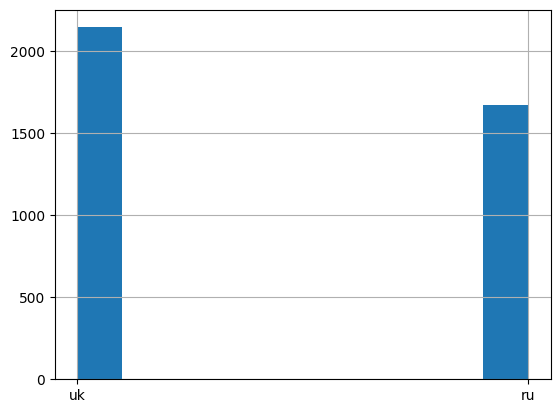

In [23]:
span_detection_tbl["lang"].hist()

Check length of samples

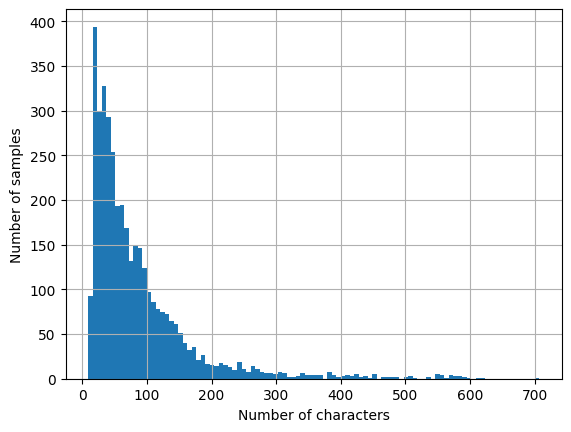

In [24]:
import matplotlib.pyplot as plt
lengths = span_detection_tbl['content'].map(lambda x: len(x.split()))
lengths.hist(bins=100)
plt.xlabel('Number of characters')
plt.ylabel('Number of samples')
plt.show()

In [25]:
lengths.describe()

count    3822.000000
mean       86.093145
std        85.902422
min         9.000000
25%        33.000000
50%        60.000000
75%       106.000000
max       707.000000
Name: content, dtype: float64

In [26]:
span_detection_tbl.iloc[lengths.idxmax()]

id                            14caf769-4d35-4bfe-ac2d-ccfbc8b63ad2
content          Божевільне таксі. З неопублікованого \nЄ в мен...
lang                                                            uk
manipulative                                                  True
techniques                     [loaded_language, euphoria, cliche]
trigger_words    [[0, 16], [47, 54], [105, 111], [158, 195], [1...
Name: 3344, dtype: object

In [27]:
span_detection_tbl.iloc[lengths.idxmax()]['trigger_words']

array([array([ 0, 16], dtype=int64), array([47, 54], dtype=int64),
       array([105, 111], dtype=int64), array([158, 195], dtype=int64),
       array([198, 256], dtype=int64), array([331, 364], dtype=int64),
       array([370, 418], dtype=int64), array([531, 567], dtype=int64),
       array([572, 612], dtype=int64), array([640, 652], dtype=int64),
       array([720, 753], dtype=int64), array([759, 838], dtype=int64),
       array([840, 861], dtype=int64), array([884, 913], dtype=int64),
       array([979, 984], dtype=int64), array([992, 996], dtype=int64),
       array([1019, 1032], dtype=int64), array([1057, 1064], dtype=int64),
       array([1097, 1113], dtype=int64), array([1144, 1161], dtype=int64),
       array([1218, 1281], dtype=int64), array([1311, 1338], dtype=int64),
       array([1416, 1436], dtype=int64), array([1438, 1540], dtype=int64),
       array([1544, 1549], dtype=int64), array([1569, 1576], dtype=int64),
       array([1606, 1662], dtype=int64), array([1678, 1708], 

Check length of tokenized samples

In [28]:
from transformers import AutoTokenizer
model_checkpoint = 'EvanD/xlm-roberta-base-ukrainian-ner-ukrner'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Token indices sequence length is longer than the specified maximum sequence length for this model (1080 > 512). Running this sequence through the model will result in indexing errors


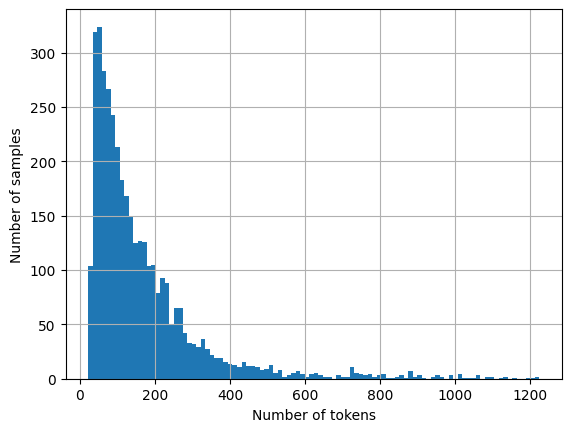

In [29]:
import matplotlib.pyplot as plt
lengths_tokenized = span_detection_tbl['content'].map(lambda x: len(tokenizer(x)['input_ids']))
lengths_tokenized.hist(bins=100)
plt.xlabel('Number of tokens')
plt.ylabel('Number of samples')
plt.show()

In [30]:
lengths_tokenized.describe()

count    3822.000000
mean      166.865515
std       160.763195
min        22.000000
25%        67.000000
50%       117.000000
75%       206.000000
max      1224.000000
Name: content, dtype: float64

In [31]:
span_detection_tbl.iloc[lengths.idxmax()]

id                            14caf769-4d35-4bfe-ac2d-ccfbc8b63ad2
content          Божевільне таксі. З неопублікованого \nЄ в мен...
lang                                                            uk
manipulative                                                  True
techniques                     [loaded_language, euphoria, cliche]
trigger_words    [[0, 16], [47, 54], [105, 111], [158, 195], [1...
Name: 3344, dtype: object

Create dataset with windowed spans

In [32]:
import re
from typing import List, Dict, Any

def window_dataset(dataset: List[Dict[str, Any]], window_size: int = 200, overlap: int = 50) -> List[Dict[str, Any]]:
    """
    Process a dataset by creating windows of text with overlapping content,
    adjusting span annotations accurately based on character positions.
    
    Args:
        dataset: List of dictionaries, each with 'id', 'content', 'lang', 
                'manipulative','techniques', and 'trigger_words' keys
        window_size: Number of words in each window
        overlap: Number of words that overlap between consecutive windows
        
    Returns:
        A new dataset with windowed content and adjusted trigger word spans
    """
    windowed_dataset = []
    
    for item in dataset.iterrows():
        item = item[1]
        content = item['content']
        trigger_words = item['trigger_words']
        
        # Split content into words
        words = re.findall(r'\s*\S+\s*', content)
        
        # If content is smaller than window_size, keep as is
        if len(words) <= window_size:
            windowed_dataset.append({
                'id': item['id'],
                'content': content,
                'lang': item['lang'],
                'manipulative': item['manipulative'],
                'techniques': item['techniques'],
                'trigger_words': trigger_words
            })
            continue
        
        # Create windows
        windows = []
        for start_idx in range(0, len(words), window_size - overlap):
            end_idx = min(start_idx + window_size, len(words))
            window_words = words[start_idx:end_idx]
            window_text = "".join(window_words)
            
            # Find the exact position of this window in the original text
            if start_idx == 0:
                # First window starts at the beginning
                window_start_pos = 0
            else:
                # Find position of the first word in this window
                prefix = "".join(words[:start_idx])
                window_start_pos = len(prefix) + 1  # +1 for the space after prefix
            
            window_end_pos = window_start_pos + len(window_text)
            
            windows.append({
                'text': window_text,
                'start_pos': window_start_pos,
                'end_pos': window_end_pos
            })
            
            # Break if we've reached the end of the text
            if end_idx >= len(words):
                break
        
        # Create new dataset items for each window with adjusted spans
        for i, window in enumerate(windows):
            new_item = {
                'id': item['id'],
                'content': window['text'],
                'lang': item['lang'],
                'manipulative': item['manipulative'],
                'techniques': item['techniques'],
                'trigger_words': []
            }
            
            # Extract exact substrings for trigger words from original content
            if trigger_words is not None:
                triggers_text = []
                for span in trigger_words:
                    orig_start, orig_end = span
                    triggers_text.append(content[orig_start:orig_end])
            
            # Find these triggers in the window text
                for j, trigger_text in enumerate(triggers_text):
                    orig_start, orig_end = trigger_words[j]
                    
                    # Check if the original span overlaps with this window
                    if (orig_end > window['start_pos'] and orig_start <= window['end_pos']):
                        # Find all occurrences in the window
                        window_text = window['text']
                        start_pos = 0
                        while start_pos < len(window_text):
                            pos = window_text.find(trigger_text, start_pos)
                            if pos == -1:
                                break
                                
                            # Add the adjusted span
                            new_item['trigger_words'].append([pos, pos + len(trigger_text)])
                            start_pos = pos + 1  # Move to find next occurrence
            
            # Only add window if it contains at least one trigger word
            if new_item['trigger_words']:
                windowed_dataset.append(new_item)
            else:
                # Optionally, you might want to keep windows without trigger words
                # Uncomment this if you want to keep all windows
                new_item['trigger_words'] = []
                windowed_dataset.append(new_item)
                pass
                
    return windowed_dataset

# usage:
windowed_data = window_dataset(span_detection_tbl, window_size=512, overlap=0)

In [16]:
num = 55
for tw in span_detection_tbl.iloc[num]['trigger_words']:
    print(span_detection_tbl.iloc[num]['content'][tw[0]:tw[1]])

«оранжевую революцию» еще за два года до ее начала стали готовить сыновья Бжезинского
на ее реализацию было направлено три из четырех основных подразделенный США по психологической войне
Что он только что из Лондона и сам, будучи в офисе Березовского, слышал, как тот кричал в трубку Жвании: «Уберите со сцены эту кокаинистку, она нам все планы поломает!»
о финансировании (помимо США) со стороны Березовского
«этот зверинец»
думаю, общую атмосферу в Киеве за пределами досягаемости телекамер 5 канала, мне в какой-то мере, удалось передать


In [17]:
wnum = 61
for tw in windowed_data[wnum]['trigger_words']:
    print(windowed_data[wnum]['content'][tw[0]:tw[1]])

«оранжевую революцию» еще за два года до ее начала стали готовить сыновья Бжезинского
на ее реализацию было направлено три из четырех основных подразделенный США по психологической войне
Что он только что из Лондона и сам, будучи в офисе Березовского, слышал, как тот кричал в трубку Жвании: «Уберите со сцены эту кокаинистку, она нам все планы поломает!»


In [18]:
wnum = 62
for tw in windowed_data[wnum]['trigger_words']:
    print(windowed_data[wnum]['content'][tw[0]:tw[1]])

Что он только что из Лондона и сам, будучи в офисе Березовского, слышал, как тот кричал в трубку Жвании: «Уберите со сцены эту кокаинистку, она нам все планы поломает!»
о финансировании (помимо США) со стороны Березовского
«этот зверинец»


In [19]:
wnum = 63
for tw in windowed_data[wnum]['trigger_words']:
    print(windowed_data[wnum]['content'][tw[0]:tw[1]])

думаю, общую атмосферу в Киеве за пределами досягаемости телекамер 5 канала, мне в какой-то мере, удалось передать


In [33]:
windowed_data_df = pd.DataFrame(windowed_data)
windowed_data_df

,id,content,lang,manipulative,techniques,trigger_words
0,0bb0c7fa-101b-4583-a5f9-9d503339141c,Новий огляд мапи DeepState від російського вій...,uk,True,"[euphoria, loaded_language]","[[27, 63], [65, 88], [90, 183], [186, 308]]"
1,7159f802-6f99-4e9d-97bd-6f565a4a0fae,Недавно 95 квартал жёстко поглумился над русск...,ru,True,"[loaded_language, cherry_picking]","[[0, 40], [123, 137], [180, 251], [253, 274]]"
2,e6a427f1-211f-405f-bd8b-70798458d656,🤩\nТим часом йде евакуація Бєлгородського авто...,uk,True,"[loaded_language, euphoria]","[[55, 100]]"
3,1647a352-4cd3-40f6-bfa1-d87d42e34eea,В Україні найближчим часом мають намір посилит...,uk,False,None,None
4,9c01de00-841f-4b50-9407-104e9ffb03bf,"Расчёты 122-мм САУ 2С1 ""Гвоздика"" 132-й бригад...",ru,True,[loaded_language],"[[114, 144]]"
...,...,...,...,...,...,...
3846,0e5dd135-ef41-48d3-b274-faedf3a2126c,🤭\nросія ставить ППО на дахах адмінбудівель\nр...,uk,True,"[loaded_language, euphoria]","[[2, 7], [43, 75], [77, 143], [145, 178], [340..."
3847,08e6772a-9793-4ec9-babd-2a9e0e8b31f9,"К слову, Бабий не просто «ларечник», а и челов...",ru,True,[loaded_language],"[[25, 35], [103, 128], [149, 166]]"
3848,d7cfa984-46f2-450d-b4ec-28a0b5d93756,"Глава ФСБ Бортников ответил журналистам, почем...",ru,False,None,None
3849,4256b2b8-43bc-4d90-95c4-5fb25f1ab0e3,В ДНР завозили наркотики в бытовой технике\nОб...,ru,False,None,None


In [21]:
prev_item = None
indxs = []
for item in windowed_data_df.iterrows():
    inx = item[0]
    item = item[1]
    if prev_item is not None:
        if item['id'] == prev_item['id'] and item['trigger_words'] is not None and item['trigger_words'] != []:
            print(inx)
            indxs.append(inx)
    prev_item = item

10
15
62
63
73
89
127
132
153
154
204
262
263
282
310
326
328
374
393
400
408
410
411
412
420
454
467
490
491
531
533
536
563
584
591
592
593
612
613
639
643
652
655
660
661
662
681
682
697
722
731
732
772
773
774
787
797
802
833
858
879
880
889
897
898
916
918
948
975
1000
1038
1039
1040
1055
1072
1091
1107
1108
1110
1111
1112
1134
1152
1155
1171
1180
1200
1219
1231
1237
1267
1274
1289
1304
1320
1437
1439
1448
1469
1470
1488
1501
1503
1506
1514
1537
1588
1619
1620
1664
1685
1705
1779
1817
1818
1824
1833
1834
1835
1863
1866
1888
1895
1898
1912
1913
1916
1919
1920
1964
1984
1985
2003
2024
2057
2062
2063
2127
2148
2151
2153
2163
2192
2197
2198
2199
2202
2236
2266
2283
2320
2323
2324
2325
2335
2355
2387
2388
2423
2446
2452
2465
2495
2504
2528
2531
2534
2546
2565
2575
2592
2593
2597
2598
2602
2633
2662
2697
2704
2707
2708
2713
2772
2776
2777
2778
2781
2782
2798
2799
2800
2826
2827
2859
2866
2867
2868
2885
2886
2887
2894
2911
2921
2966
2967
2968
2985
3075
3089
3090
3091
3093
3094
3100
3132


In [22]:
print(len(indxs))

285


Saving

In [34]:
windowed_data_df.to_parquet(RAW_DATA_FOLDER / "span-detection-windowed.parquet")

## Techniques classification

In [ ]:
techniques_classification_tbl = pd.read_parquet(
    RAW_DATA_FOLDER / "techniques-classification.parquet"
)

techniques_classification_tbl.head(5)

In [ ]:
len(techniques_classification_tbl)